In [1]:
!pip install numpy pandas simpleitk matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!source setup.sh

8500
1.13.0+cu117
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/zce5py/Desktop/nnUNet
  Attempting uninstall: nnunet
    Found existing installation: nnunet 1.7.0
    Uninstalling nnunet-1.7.0:
      Successfully uninstalled nnunet-1.7.0
  Running setup.py develop for nnunet
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/FabianIsensee/hiddenlayer.git (to revision more_plotted_details) to /tmp/pip-install-kgyaq5pu/hiddenlayer
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=19811 sha256=e43965d1da8a5d81af4b429af1b14821dd9c36a8e0ce169a2041c86df2e6b59e
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1cg8o42/wheels/ba/64/4b/a960398ddff6d8fdbd45a3daa618eacc7806502eae6b32407f
Successfully built hiddenlayer
  Attempting uninstall: hiddenlayer
    Found existing installation: hiddenlayer 0.2
    Uninstalling hiddenlayer-0.2:
      Succ

3360 train 380 test
file_id examples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177]
(240, 240) (240, 240)


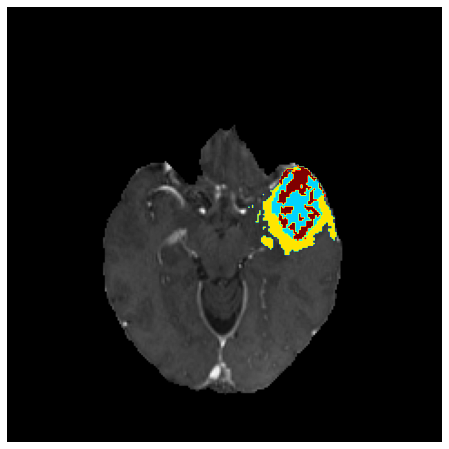

In [15]:
import SimpleITK as sitk
import matplotlib.pylab as plt
import os
import pandas as pd
import numpy as np


TASK_NAME = 'Task501_BrainTumor'
# TASK_NAME = 'Task500_BrainTumor'


TRAIN_IMAGES = f'nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/imagesTr'
TRAIN_LABELS = f'nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/labelsTr'
TEST_IMAGES = f'nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/imagesTs'
TEST_LABELS = f'nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/labelsTs'

train_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TRAIN_IMAGES) if fpath.endswith('.nii.gz')]
train_ids.sort()

test_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TEST_IMAGES) if fpath.endswith('.nii.gz')]
test_ids.sort()

print(len(train_ids), 'train', len(test_ids), 'test') 
print('file_id examples:', train_ids[:30])

id = 0 # set this to the image/subject ID

def visualize(image, label):
    plt.figure(figsize=(8,8))
    plt.imshow(image, cmap='gray')

    alpha = label.copy()
    alpha[alpha>0] = 1
    plt.imshow(label, alpha=alpha, cmap='jet')
    plt.axis('off')
    plt.show()
    
    
image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_IMAGES, f"BRATS_{str(id).zfill(5)}_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()

print(image.shape, label.shape)

visualize(image, label)

### Metrics

In [20]:
from nnunet.evaluation.evaluator import *
from nnunet.evaluation.region_based_evaluation import *
from nnunet.dataset_conversion.Task082_BraTS_2020 import * 


df_list = []

TRAIN_REF_PATH = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/labelsTr"

TRAINER_CLASSES = ["nnUNetTrainerV2BraTSRegions", "nnUNetTrainerV2BraTSRegions_BN", "nnUNetTrainerV2BraTSRegions_DA3", "nnUNetTrainerV2BraTSRegions_Dice", "nnUNetTrainerV2BraTSRegions_DA3_BN", "nnUNetTrainerV2BraTSRegions_DA3_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN", "nnUNetTrainerV2BraTSRegions_DA3_BN_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN_BD", "ensemble"]

if '501' in TASK_NAME:
    TRAINER_CLASSES = ["nnUNetTrainerV2BraTSRegions", "nnUNetTrainerV2BraTSRegions_BN", "nnUNetTrainerV2BraTSRegions_Dice", "nnUNetTrainerV2BraTSRegions_DA4_BN", "nnUNetTrainerV2BraTSRegions_DA3_BN_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN_BD", "ensemble"]

else:
    print('get fold 0 training metrics')
    
    for TRAINER_CLASS in TRAINER_CLASSES:
        TRAIN_VAL_PATH = f"nnUNet_trained_models/nnUNet/2d/{TASK_NAME}/{TRAINER_CLASS}__nnUNetPlansv2.1/fold_0/validation_raw"

        evaluate_BraTS_folder(TRAIN_VAL_PATH, TRAIN_REF_PATH)

        # summary_df = pd.read_csv(f"{TRAIN_VAL_PATH}/summary.csv")
        summary_df = pd.read_csv(f"{TRAIN_VAL_PATH}/results.csv")

        print(TRAINER_CLASS)
        print('================')
        print('MEAN=')
        print(summary_df.mean(axis=0))

        print('\nSTD=')
        print(summary_df.std(axis=0))

        print('\n================\n')

        df_list.append([TRAINER_CLASS]+list(summary_df.mean(axis=0).values))

        summary_df.to_csv(f'results/{TASK_NAME}_train_{TRAINER_CLASS}.csv')



    df_train = pd.DataFrame(df_list, columns=['trainer_class','dc_whole','dc_core','dc_enh','hd95_whole','hd95_core','hd95_enh'])
    df_train.to_csv(f'{TASK_NAME}_train_metrics.csv')
    df_train

In [17]:
REF_PATH = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/labelsTs"
PRED_PATH_MAIN = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/predTs"

df_list = []

print('\n=========================\nTEST SET')

for TRAINER_CLASS in TRAINER_CLASSES:
    PRED_PATH = f'{PRED_PATH_MAIN}_{TRAINER_CLASS}'
    
    evaluate_BraTS_folder(PRED_PATH, REF_PATH)
    
    summary_df = pd.read_csv(f'{PRED_PATH}/results.csv')
    summary_df.to_csv(f'results/{TASK_NAME}_test_{TRAINER_CLASS}.csv')
    
    print(TRAINER_CLASS)
    print('================')
    print('MEAN=')
    print(summary_df.mean(axis=0))
    
    print('\nSTD=')
    print(summary_df.std(axis=0))
    
    print('\n================\n')
    
    df_list.append([TRAINER_CLASS]+list(summary_df.mean(axis=0).values))
    
df_test = pd.DataFrame(df_list, columns=['trainer_class','dc_whole','dc_core','dc_enh','hd95_whole','hd95_core','hd95_enh'])
df_test.to_csv(f'{TASK_NAME}_test_metrics.csv')
df_test


TEST SET
nnUNetTrainerV2BraTSRegions
MEAN=
dc_whole       0.624409
dc_core        0.597536
dc_enh         0.802456
hd95_whole    62.084871
hd95_core     63.063853
hd95_enh      34.585216
dtype: float64

STD=
dc_whole        0.369235
dc_core         0.352734
dc_enh          0.293317
hd95_whole    127.904684
hd95_core     128.725322
hd95_enh      104.634392
dtype: float64


nnUNetTrainerV2BraTSRegions_BN
MEAN=
dc_whole       0.659064
dc_core        0.632263
dc_enh         0.835056
hd95_whole    72.676374
hd95_core     73.041911
hd95_enh      25.425545
dtype: float64

STD=
dc_whole        0.357310
dc_core         0.346516
dc_enh          0.257512
hd95_whole    141.927606
hd95_core     141.768634
hd95_enh       90.477319
dtype: float64


nnUNetTrainerV2BraTSRegions_Dice
MEAN=
dc_whole       0.595846
dc_core        0.570357
dc_enh         0.729349
hd95_whole    54.844966
hd95_core     54.115097
hd95_enh      60.127716
dtype: float64

STD=
dc_whole        0.377567
dc_core         0.359996
d

,trainer_class,dc_whole,dc_core,dc_enh,hd95_whole,hd95_core,hd95_enh
0,nnUNetTrainerV2BraTSRegions,0.624409,0.597536,0.802456,62.084871,63.063853,34.585216
1,nnUNetTrainerV2BraTSRegions_BN,0.659064,0.632263,0.835056,72.676374,73.041911,25.425545
2,nnUNetTrainerV2BraTSRegions_Dice,0.595846,0.570357,0.729349,54.844966,54.115097,60.127716
3,nnUNetTrainerV2BraTSRegions_DA4_BN,0.630663,0.603856,0.797464,70.490279,70.600792,34.467284
4,nnUNetTrainerV2BraTSRegions_DA3_BN_BD,0.649914,0.624353,0.820719,71.880505,71.323111,31.484329
5,nnUNetTrainerV2BraTSRegions_DA4_BN_BD,0.654227,0.625458,0.822729,77.062034,77.463339,30.386863
6,ensemble,0.654588,0.625838,0.822639,76.097605,76.515487,31.286103


### Test Set Predictions - Visualize

In [32]:
PRED_PATH_MAIN = f"nnUNet_raw_data_base/nnUNet_raw_data/{TASK_NAME}/predTs"

PRED_PATHS = []
for TRAINER_CLASS in TRAINER_CLASSES:
    PRED_PATH = f'{PRED_PATH_MAIN}_{TRAINER_CLASS}'
    print(PRED_PATH)
    PRED_PATHS.append(PRED_PATH)
    
PRED_LABELS = PRED_PATHS[-1] # selecting last - the best

print('\n==================\nUSING PRED_LABELS=', PRED_LABELS)
test_summary_df = pd.read_csv(f'{PRED_LABELS}/results.csv')
final_metrics_table = pd.DataFrame([test_summary_df.mean(axis=0), test_summary_df.std(axis=0), test_summary_df.median(axis=0), test_summary_df.quantile(axis=0, q=0.25), test_summary_df.quantile(axis=0, q=0.75)], index=['mean', 'std', 'median', '25th', '75th']) 
final_metrics_table.to_csv(f'{TASK_NAME}_test_ensemble_metrics.csv')

nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_BN
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_Dice
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA3_BN_BD
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD
nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_ensemble

USING PRED_LABELS= nnUNet_raw_data_base/nnUNet_raw_data/Task501_BrainTumor/predTs_ensemble


32088


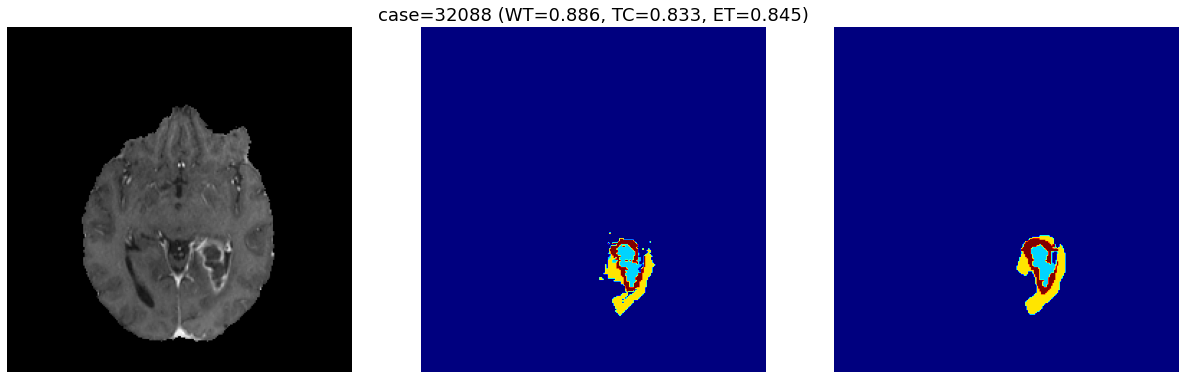

32256


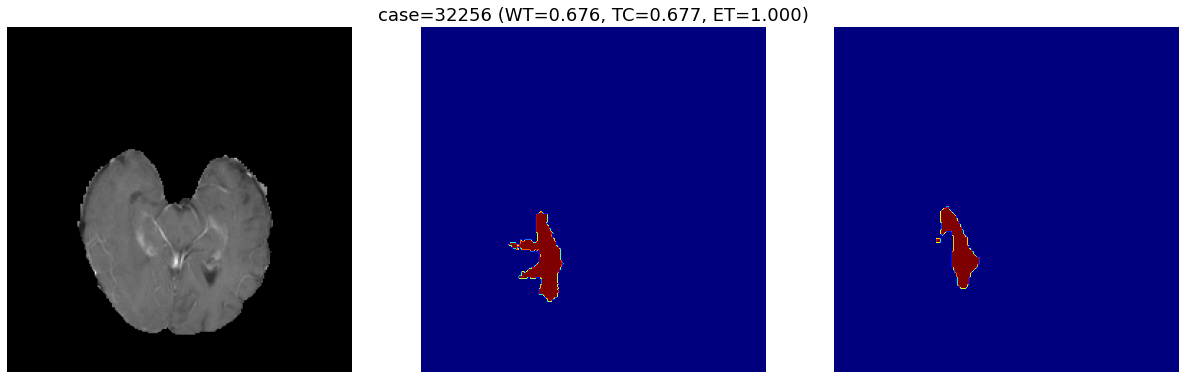

32424


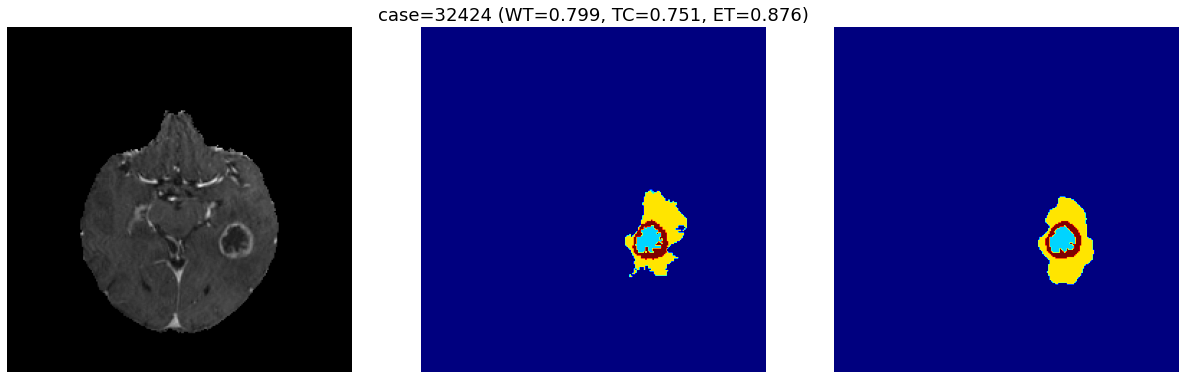

32592


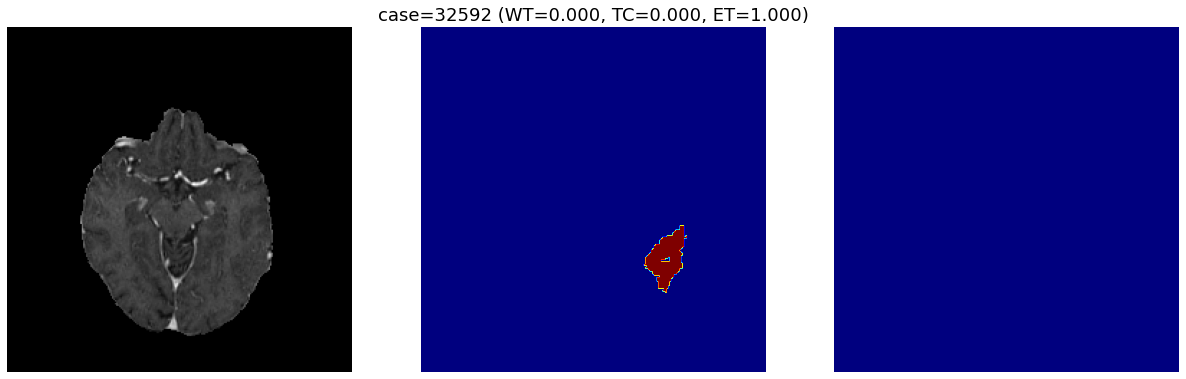

32760


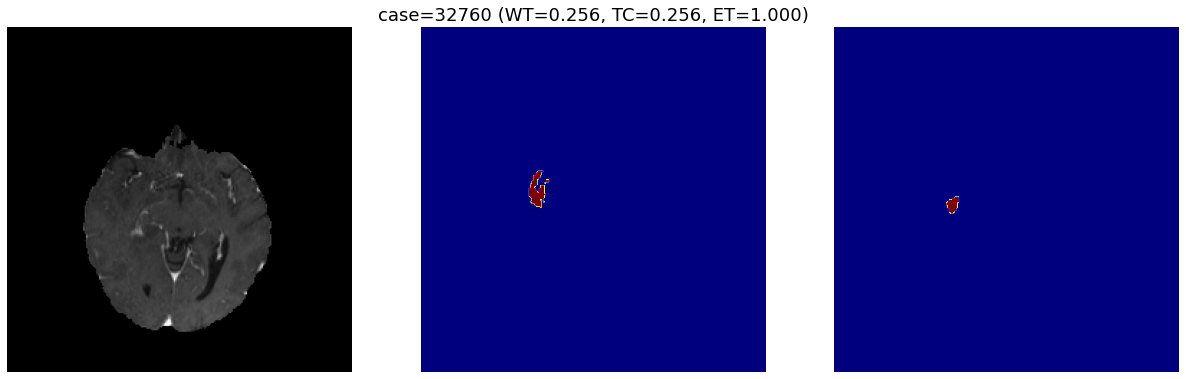

32928


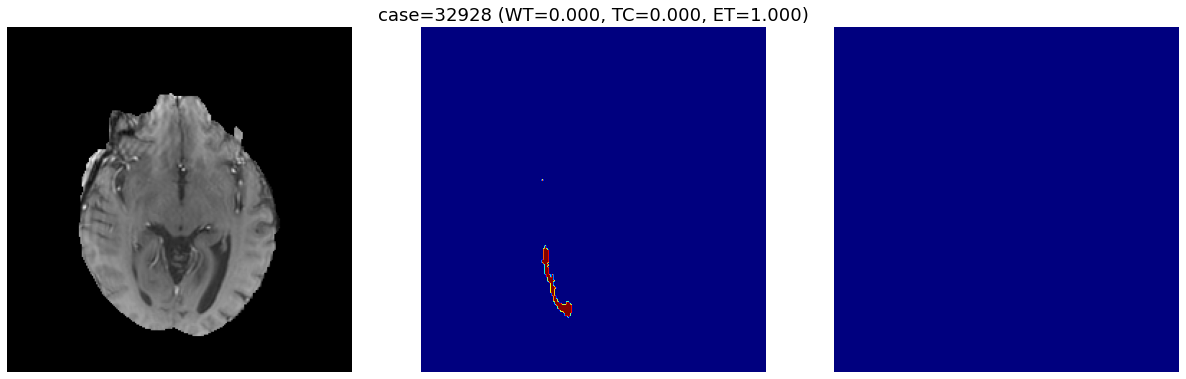

33096


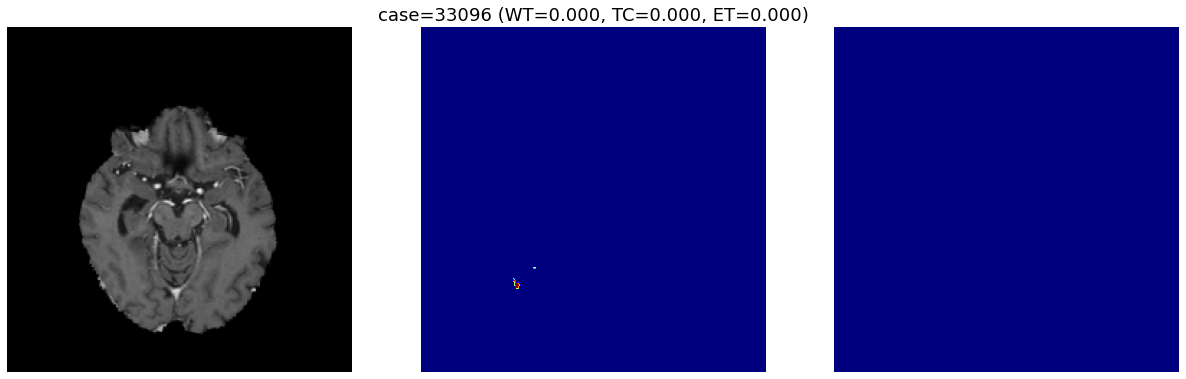

33264


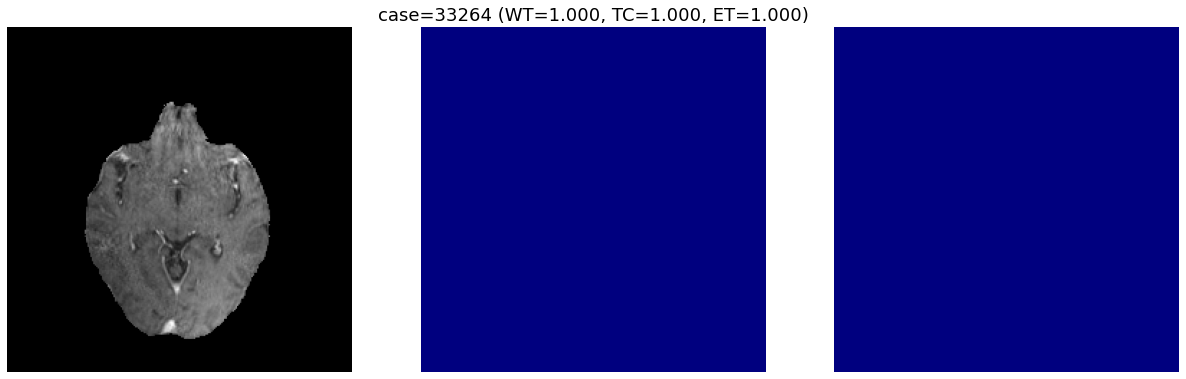

33432


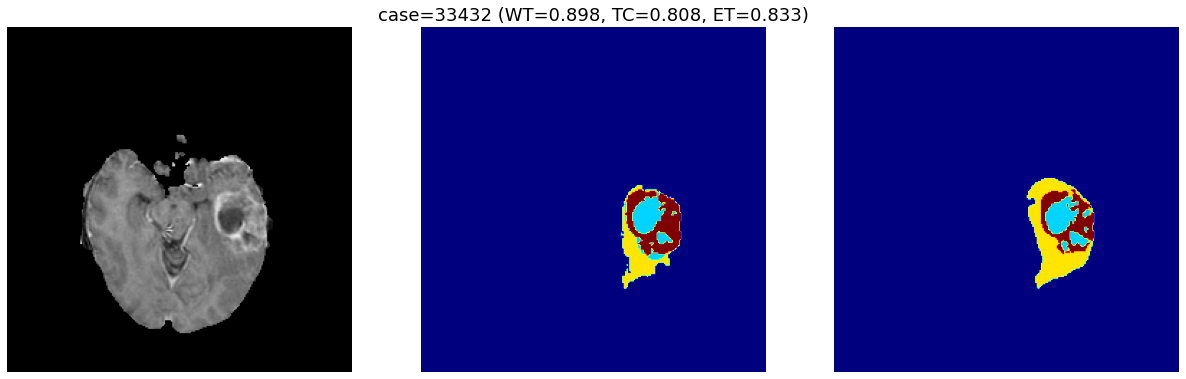

33600


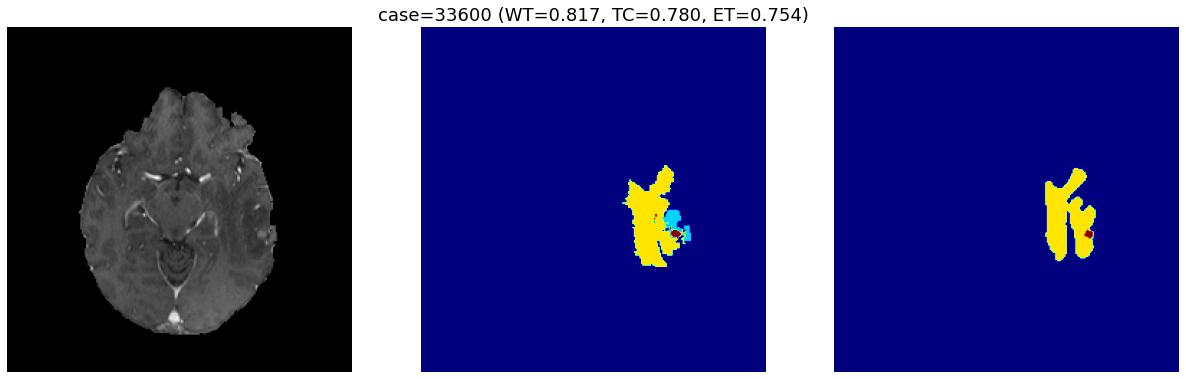

33768


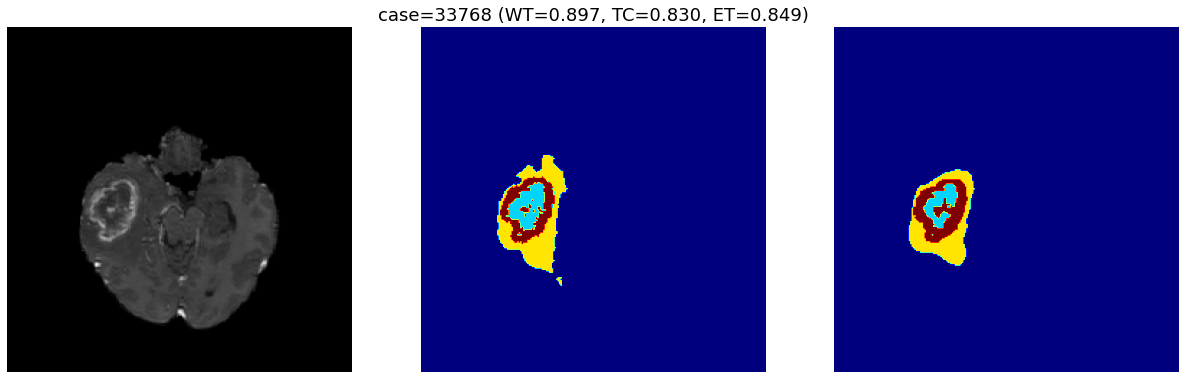

33936


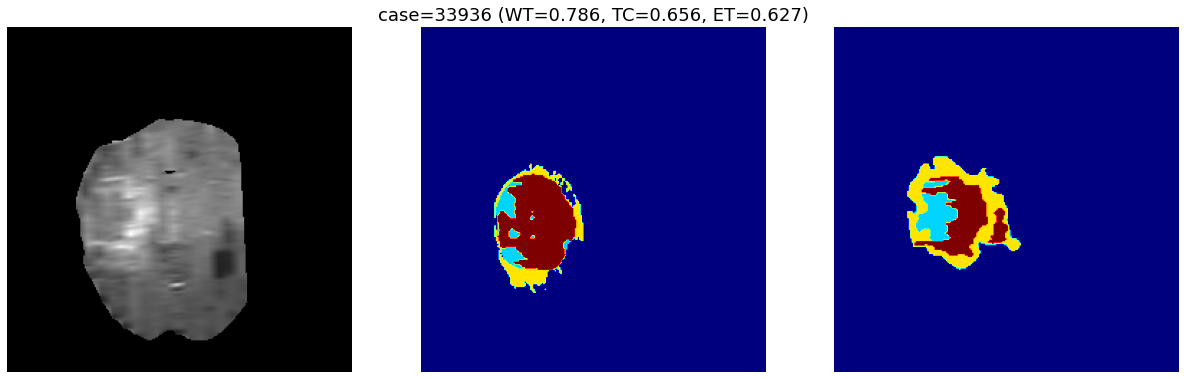

34104


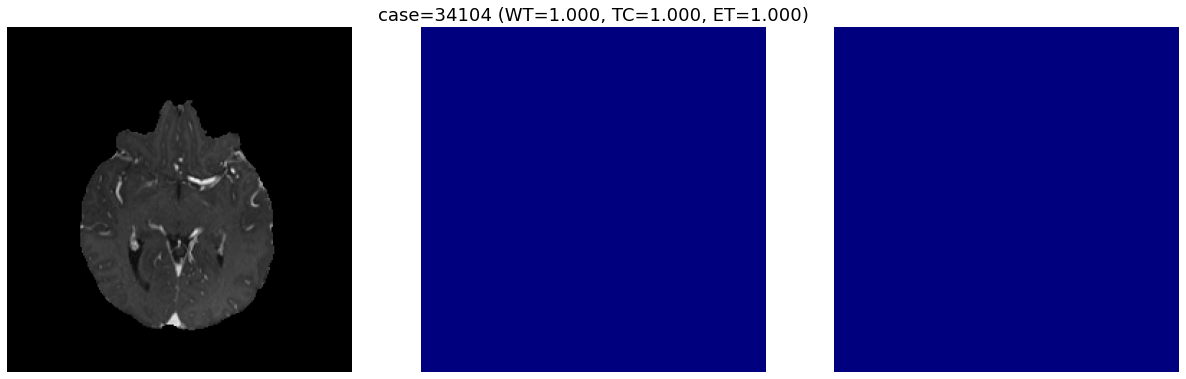

34272


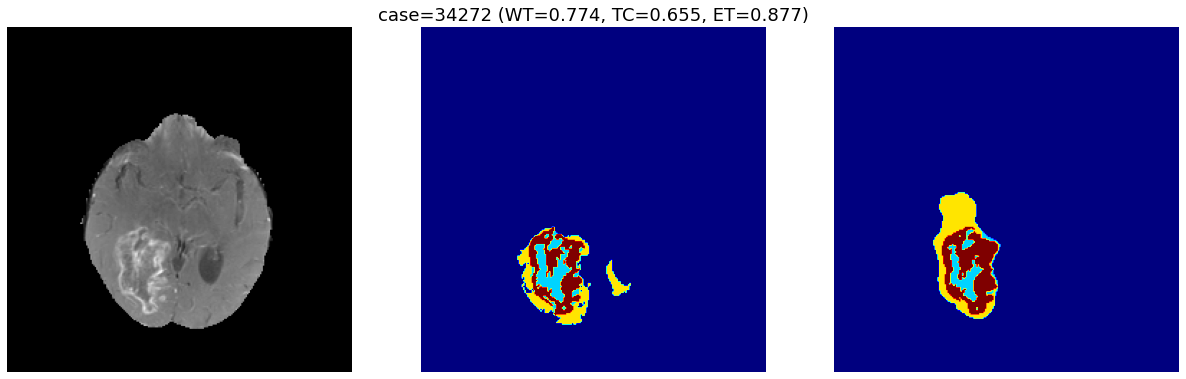

34440


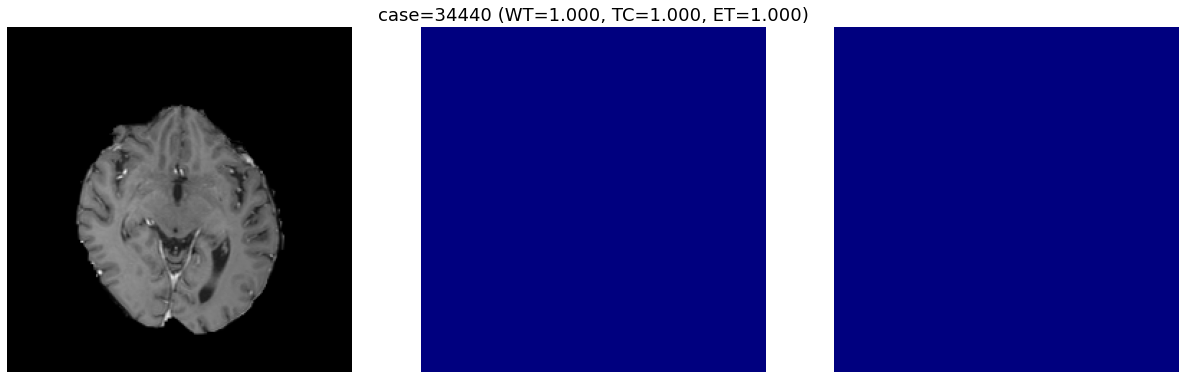

34608


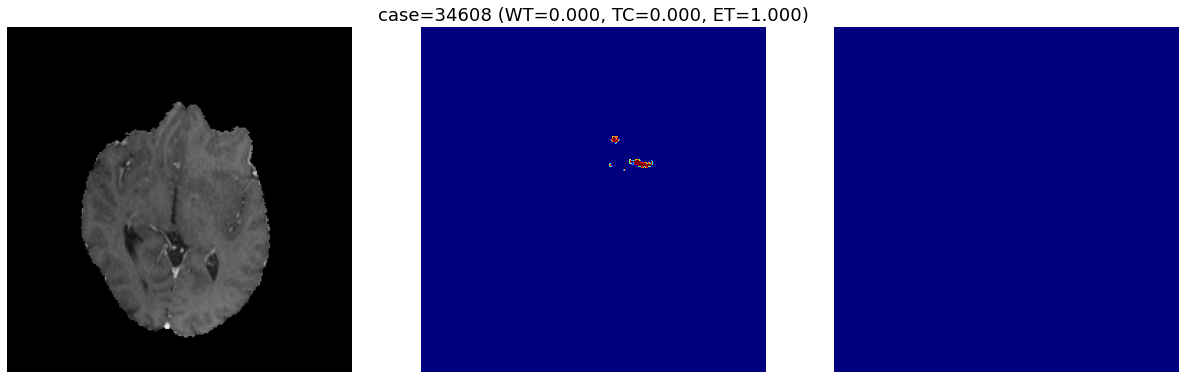

34776


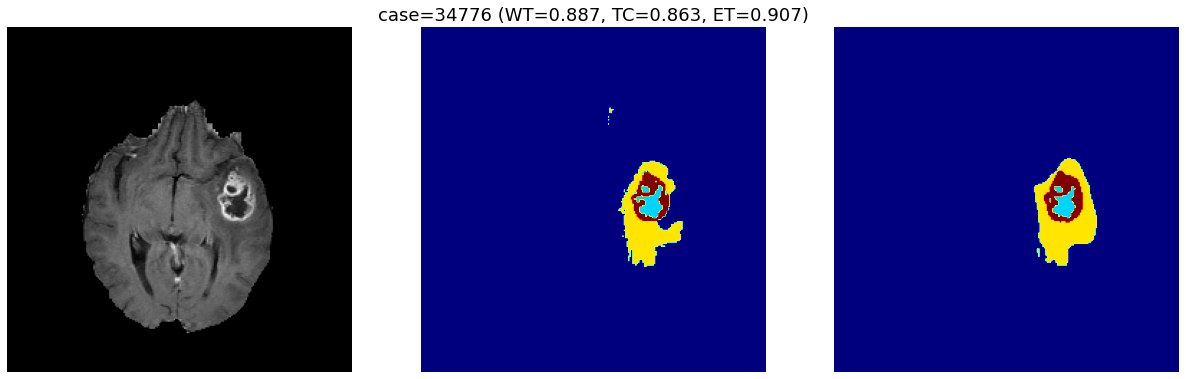

34944


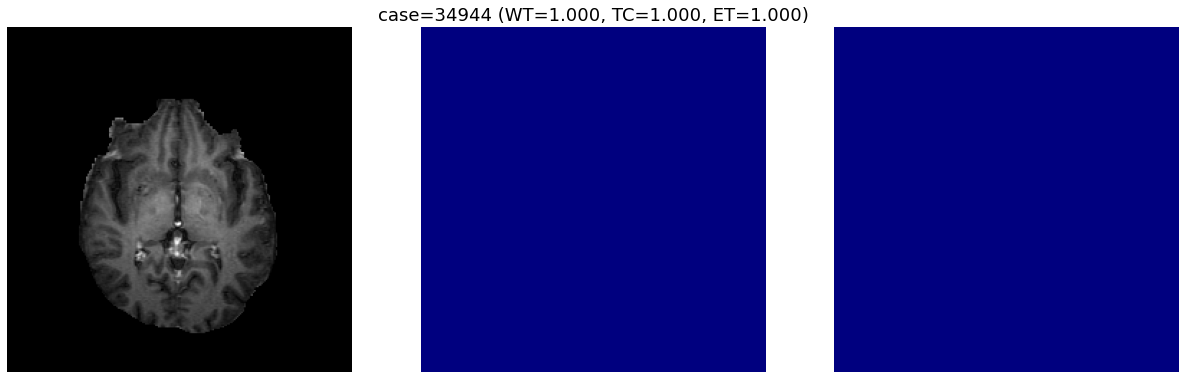

35112


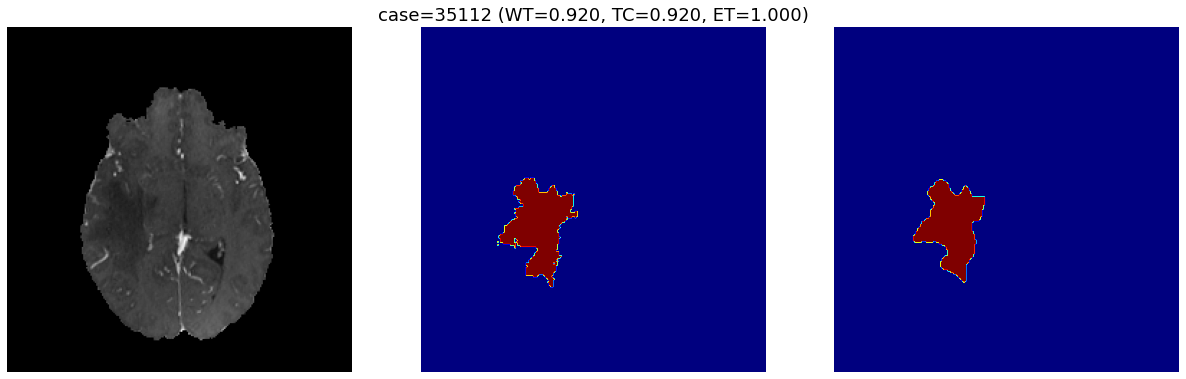

In [33]:
def visualize_side(image, label, pred_label, title=''):
    plt.figure(figsize=(21,7))
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(label, cmap='jet')
    plt.axis('off')
    plt.title(title, fontsize=18)
    
    plt.subplot(1,3,3)
    plt.imshow(pred_label, cmap='jet')
    plt.axis('off')
    
    plt.show()
    
    
    
for i in range(0, len(test_ids), 20):
    id = test_ids[i]
    print(id)
    
    fill_id = str(id).zfill(5)
    
    image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_IMAGES, f"BRATS_{fill_id}_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
    label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_LABELS, f"BRATS_{fill_id}.nii.gz"), sitk.sitkFloat32)).squeeze()
    pred_label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PRED_LABELS, f"BRATS_{fill_id}.nii.gz"), sitk.sitkFloat32)).squeeze()
    
    metrics = test_summary_df[test_summary_df['name']==f'BRATS_{fill_id}.nii.gz']
    m = metrics.values[0][1:].astype(np.float32)
#     m[np.isnan(m)] = 1
    title = f'case={id} (dc_WT={m[0]:.3f}, dc_TC={m[1]:.3f}, dc_ET={m[2]:.3f}, hd95_WT={m[0]:.3f}, hd95_TC={m[1]:.3f}, hd95_ET={m[2]:.3f})'
    title = f'case={id} (WT={m[0]:.3f}, TC={m[1]:.3f}, ET={m[2]:.3f})'

    visualize_side(image, label, pred_label, title)